In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake    
import zarr      

import seaborn as sns


In [ ]:
# I like serif fonts
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams['text.usetex'] = False
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 70 # change for figure quality



In [3]:
catfn='xsh24_update.yaml' # new version of XSHiELD that has clearsky variables
xsh24_cat = intake.open_catalog(catfn)
print (list(xsh24_cat)) 


['xsh24_coarse', 'xsh24_native']


In [4]:
# we only have level 7 for now
zoom_select = 7
ds = xsh24_cat.xsh24_coarse(zoom=zoom_select).to_dask()
ds = ds.pipe(egh.attach_coords)
ds


/home/pc6491/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 997GB
Dimensions:  (time: 3560, cell: 196608, plev: 31, pfull: 79)
Coordinates:
  * pfull    (pfull) float32 316B 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
  * plev     (plev) float32 124B 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables: (12/38)
    clivi    (time, cell) float32 3GB ...
    clt      (time, cell) float32 3GB ...
    clwvi    (time, cell) float32 3GB ...
    hflsd    (time, cell) float32 3GB ...
    hfssd    (time, cell) float32 3GB ...
    hur      (time, plev, cell) float32 87GB ...
    ...       ...
    uas      (time, cell) float32 3GB ...
    va       (time, plev, cell) float32 87GB ...
    vas      (time, cell) float32 3GB ...
    wa       (time, plev, cell) float32 87GB ...
    wap      (time, plev, cell) float32 87GB ...
    zg       (time, plev, cell) float32 87GB ...

In [5]:
# adjusted from Tim Merlis' plotting function
def worldmap(var, **kwargs):
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    ax.coastlines()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
        
    return fig, ax, cbar


In [6]:
# cloud radiative effect as the example variable
CRE = ds.rlutcs.isel(time = 0) - ds.rlut.isel(time = 0)

In [7]:
CRE

<xarray.DataArray (cell: 196608)> Size: 786kB
array([30.153778 , 24.573517 , 67.18138  , ...,  3.5531616, 15.805878 ,
        8.410492 ], shape=(196608,), dtype=float32)
Coordinates:
    time     object 8B 2019-10-20 03:00:00
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0

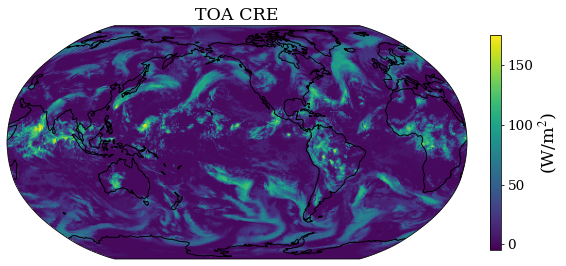

In [8]:
# look at the world map
fig, ax, cbar = worldmap(CRE)
ax.set_title("TOA CRE")
cbar.set_label(label = '(W/m$^2$)')
plt.show()


In [9]:
# Bin CRE by latitude
lat_bins = np.arange(-90, 91, 10)
lat_binned = CRE.groupby_bins(CRE.lat, bins=lat_bins)

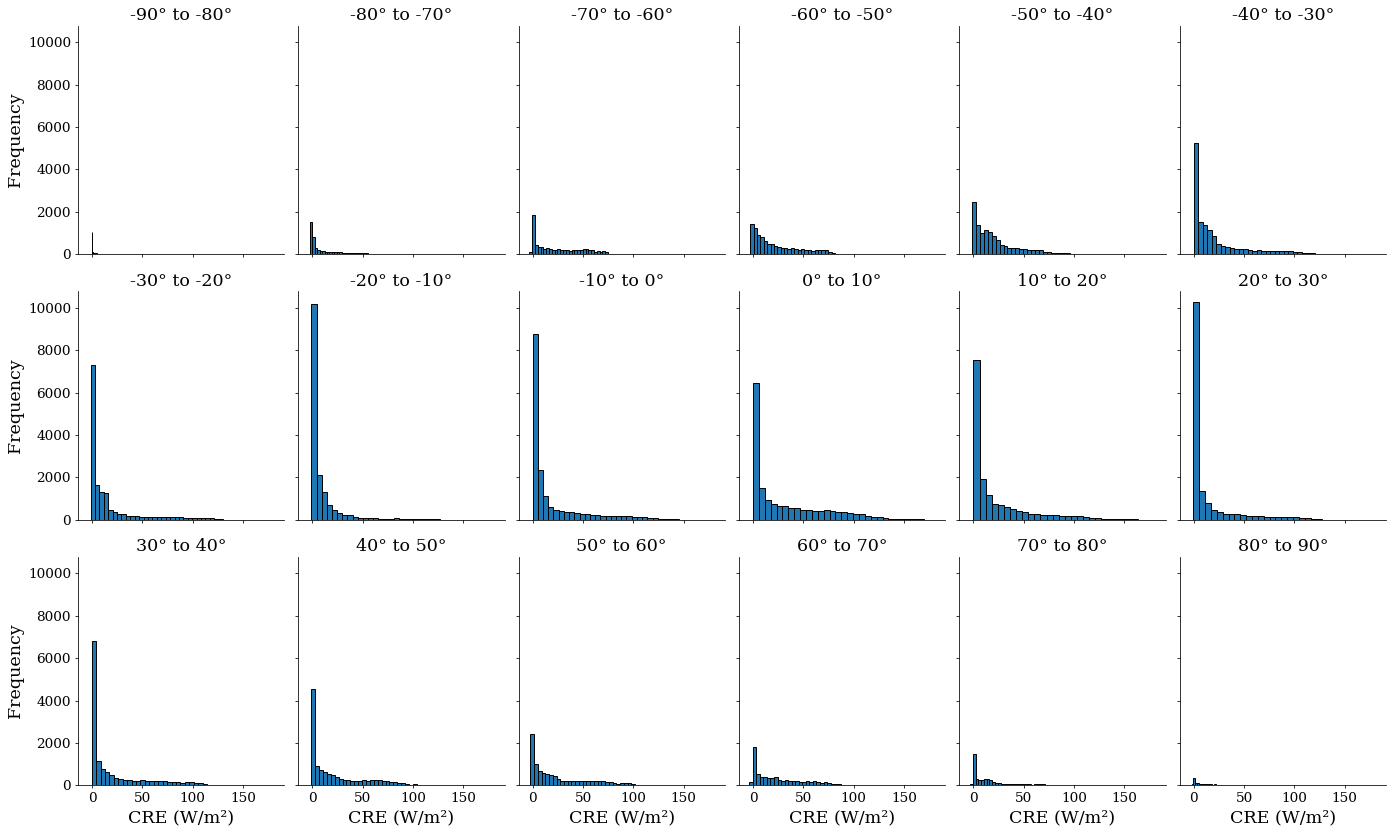

In [10]:
# Show histograms of CRE in each bin
fig, axes = plt.subplots(3, 6, figsize=(20, 12), sharex = True, sharey = True)
axes = axes.flatten()

# Iterate through the latitude bins and create histograms
for i, (bin_name, bin_data) in enumerate(lat_binned):
    bin_start, bin_end = bin_name.left, bin_name.right
    
    # Create histogram in the corresponding subplot
    axes[i].hist(bin_data, bins=30, edgecolor='black')
    axes[i].set_title(f'{bin_start:.0f}° to {bin_end:.0f}°')
    if i == 0 or i == 6 or i == 12:
        axes[i].set_ylabel('Frequency')
    if i >= 12:
        axes[i].set_xlabel('CRE (W/m²)')

    sns.despine()

plt.tight_layout()
plt.show()

/tmp/ipykernel_1373511/602420915.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


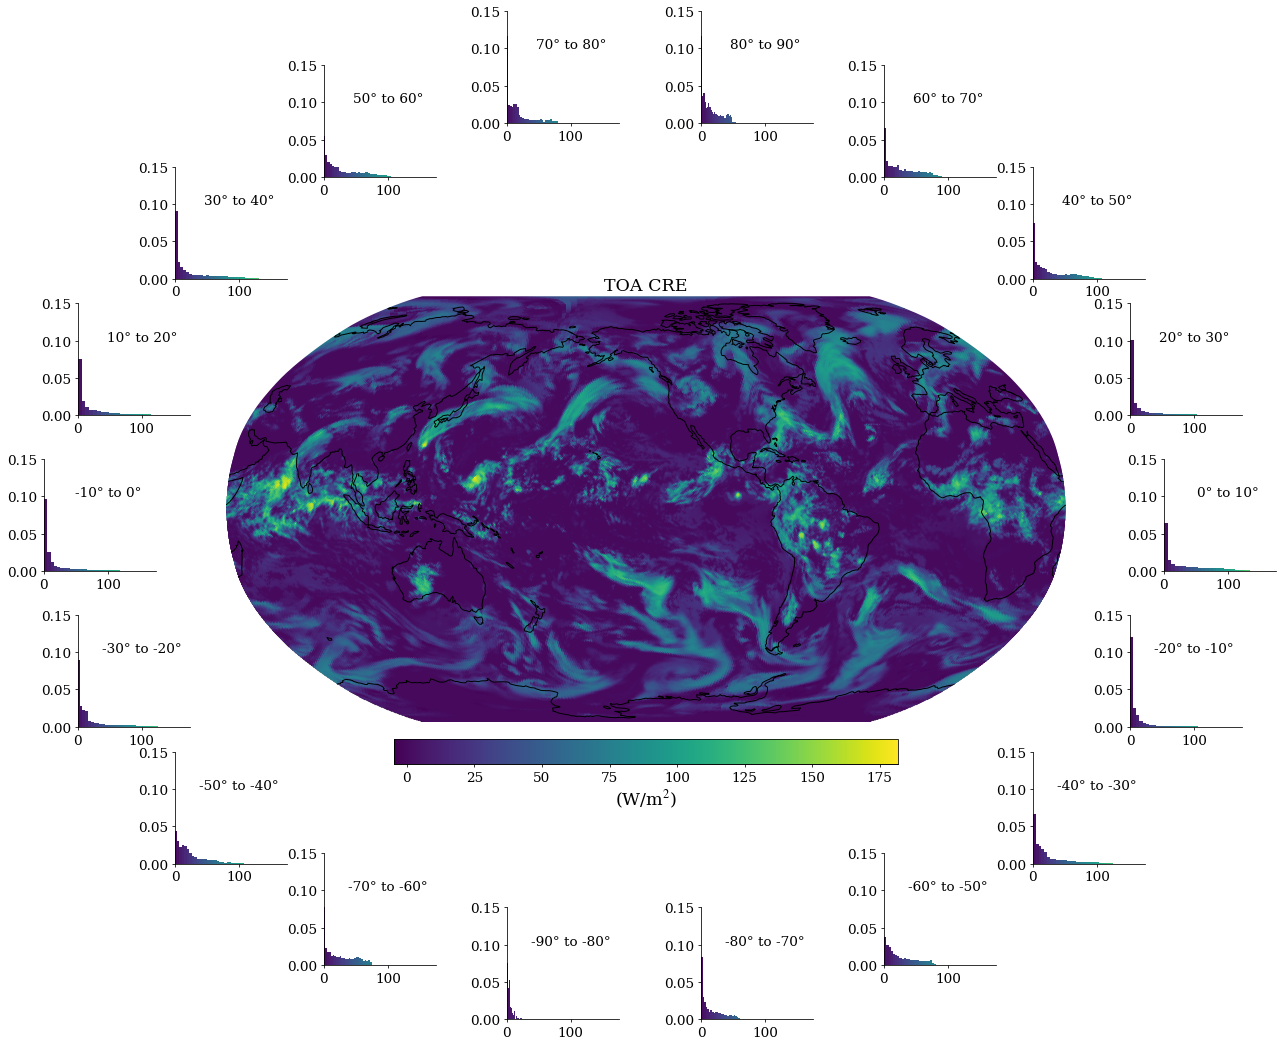

In [11]:
# create figure: map in the middle, latitudinal bins around
fig = plt.figure(figsize=(20, 20))

# Central map plot
ax_map = fig.add_axes([0.19, 0.25, 0.6, 0.6], projection = ccrs.Robinson(central_longitude = -135))
ax_map.set_global()
ax_map.coastlines()
hpshow = egh.healpix_show(CRE, ax=ax_map)
cbar = plt.colorbar(hpshow, ax=ax_map, location = 'bottom', pad=0.02, shrink=0.6)
ax_map.set_title("TOA CRE")
cbar.set_label(label='(W/m$^2$)')

# Remove map axes
ax_map.axis('off')

# Get the colormap from hpshow (so we can color-code the bars later)
cmap = hpshow.get_cmap()
norm = hpshow.norm

# Calculate positions for surrounding histograms using an elliptical arrangement
radius_x = 1.6  # Reduced horizontal spread
radius_y = 1.3  # Reduced vertical spread
angles = np.linspace(-np.pi, np.pi, 18, endpoint=False)
# we want the polar lats at the poles, equator at equator, etc.
reindex = np.array([4, 5, 3, 6, 2, 7, 1, 8, 0, 9, 17, 10, 16, 11, 15, 12, 14, 13])

for i, (bin_name, bin_data) in enumerate(lat_binned):
    bin_start, bin_end = bin_name.left, bin_name.right
    
    # Adjust angle to match latitude (reindex manually)
    lat_center = (bin_start + bin_end) / 2
    angle_adj = angles[reindex[i]]
    
    # Calculate position with elliptical adjustment
    x = radius_x * np.cos(angle_adj)
    y = radius_y * np.sin(angle_adj)
    
    # Convert to grid coordinates (0-4 range)
    x = 2 + x
    y = 2 + y
    
    # Create smaller subplot with adjusted position and size
    ax = plt.axes([x/4 - 0.04, y/4 - 0.04, 0.08, 0.08])

    # Create histogram
    n, bins, patches = ax.hist(bin_data[bin_data != 0], bins=30, edgecolor='None', density='True')
    
    # Color the histogram bars according to the central map's colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for patch, center in zip(patches, bin_centers):
        color = cmap(norm(center))
        patch.set_facecolor(color)
        
    # label the lat bin
    ax.text(100, 0.1, f'{bin_start:.0f}° to {bin_end:.0f}°', fontsize=14, ha='center')
    ax.set_xlim([0, 175])
    ax.set_ylim([0, 0.15])
    ax.patch.set_facecolor('none') #make transparent to help with overlapping subplots
    
    # Remove all axes, ticks and labels
    sns.despine()

plt.tight_layout()
plt.show()